In [84]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
from keras.utils import to_categorical
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train = x_train.reshape((len(x_train), 28 * 28)).astype('float32') / 255
x_test = x_test.reshape((len(x_test), 28 * 28)).astype('float32') / 255

# Add noise to the images (optional, but useful for denoising autoencoder)
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the pixel values to be in the range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Use the same data for input and target (denoising autoencoder)
train_labels = to_categorical(y_train, num_classes=10)
test_labels = to_categorical(y_test, num_classes=10)

y_train = x_train
y_test = x_test

x_train = x_train_noisy
x_test = x_test_noisy

# Print the shape of the data
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("train_labels shape:", train_labels.shape)
print("test_labels shape:", test_labels.shape)

x_train shape: (60000, 784)
x_test shape: (10000, 784)
y_train shape: (60000, 784)
y_test shape: (10000, 784)
train_labels shape: (60000, 10)
test_labels shape: (10000, 10)


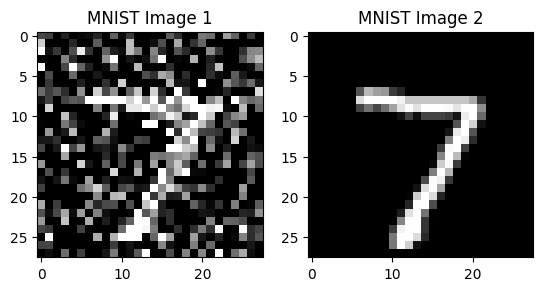

7

In [65]:
import numpy as np
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(x_test[0].reshape(28, 28), cmap='gray')
plt.title('MNIST Image 1')

plt.subplot(1, 2, 2)
plt.imshow(y_test[0].reshape(28, 28), cmap='gray')
plt.title('MNIST Image 2')

plt.show()



In [90]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

from keras import layers, models

def diffusion_with_conditioning():
    noise_input = layers.Input(shape=(28 * 28,))
    label_input = layers.Input(shape=(10,))  # Assuming 10 classes for digits 0-9

    # Concatenate noise input with label
    concatenated_input = layers.concatenate([noise_input, label_input])

    x = layers.Dense(28*28, activation='relu')(concatenated_input)
    x = layers.Dense(28*28, activation='relu')(x)
    generated_image = layers.Dense(28*28, activation='sigmoid')(x)

    model = models.Model(inputs=[noise_input, label_input], outputs=generated_image)

    return model


def create_autoencoder():
    autoencoder_model = autoencoder()
    autoencoder_model.compile(optimizer='adam', loss='mse')  # Use appropriate loss function
    return autoencoder_model

def train(model,x,y):
    model.fit(x, y, epochs=10, batch_size=128)  # Adjust epochs and batch_size

autoencoder_model = create_autoencoder()
train(autoencoder_model, [x_train, train_labels], y_train)


NameError: name 'noise_input' is not defined

313/313 [==============================] - 0s 1ms/step


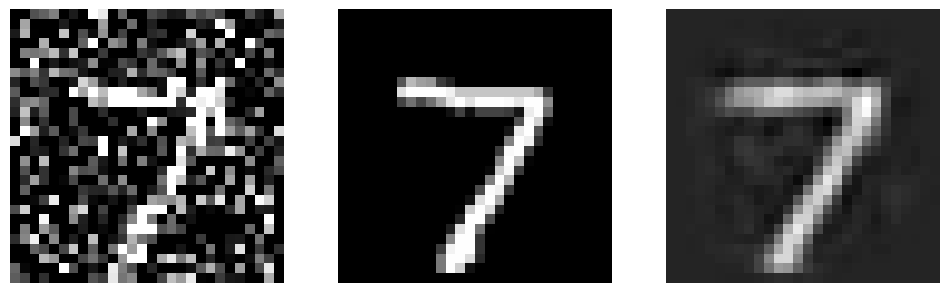

In [61]:
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt



noisy_image = x_test[0].reshape(28, 28)
original_image = y_test[0].reshape(28, 28)
recovered_image = autoencoder_model.predict(x_test)[0].reshape(28, 28)



fig, axs = plt.subplots(1, 3, figsize=(12, 4), squeeze=False)

# Plot the noisy image on the first subplot
axs[0, 0].imshow(noisy_image.astype('float'), cmap='gray')
# axs[0, 0].set_title('MNIST Image 1')

# Plot the original image on the second subplot
axs[0, 1].imshow(original_image.astype('float'), cmap='gray')
# axs[0, 1].set_title('MNIST Image 2')

# Plot the recovered image on the third subplot
axs[0, 2].imshow(recovered_image.astype('float'), cmap='gray')
# axs[0, 2].set_title('MNIST Image 3')

# Hide axes and tick labels for all subplots
for ax in axs[0]:
    ax.axis('off')

plt.show()